## Analysis of Initial Model on Audio Data and Comparison of outputs from different Dataset(Youtube, CSC, Trial, Bag of Lies)

Analysis is done on the behaviour of initial and final model. The Data corresponding to the different classes are studied


### Import necessary packages

In [5]:
import os, sys, glob, csv, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf, IPython.display as ipd, keras
from sklearn import model_selection, preprocessing
import sklearn
from os import walk, path
from keras import models, layers, optimizers, preprocessing as KRSpreps, utils as KRSutils

### Path of the frame wise Audio Data(from all data sources)

In [6]:
direc = "/home/adrikamukherjee/csv_frame_wise_fulldata"

### Preparing data for processing

Dropping unnecessary columns. Seperating labels and training data

In [7]:
df_list, label_list = [], []
for filename in glob.glob(os.path.join(direc, '*.csv')):
            df_individualfile = pd.read_csv(filename)
            count = len(df_individualfile.index)
            if(count>0):
                label = df_individualfile.loc[:, "label"].unique()[0]
                df_individualfile.drop(["name", "frameTime", "Unnamed: 0", "label"], axis = 1, inplace = True)
                df_individualfile.set_index(pd.date_range(start='2000-01-01', end='2020-01-12', 
                                                          periods = df_individualfile.shape[0]), inplace = True)
                df_individualfile.drop_duplicates(inplace = True)
                df_list.append(df_individualfile)
                label_list.append(label)

### Histogram of number of frame per audio

Finding Statistical measures for number of frames obtained for each audio file; then plotting the distribution of frames across available data

count     8886.000000
mean      1280.166329
std       1040.589240
min         69.000000
25%        695.000000
50%       1000.000000
75%       1599.000000
max      24400.000000
dtype: float64
[300.0, 400.0, 500.0, 599.0, 695.0, 700.0, 799.0, 899.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1599.0, 1799.0, 2000.0, 2400.0, 3100.0]


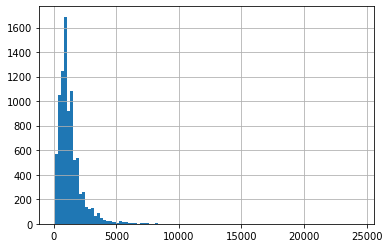

In [8]:
len_sequences = []
for one_seq in df_list:
    len_sequences.append(len(one_seq))
len_sequences = pd.Series(len_sequences)
print(len_sequences.describe())
print([val for val in [len_sequences.quantile(q = qtl) for qtl in np.arange(0.05, 1, 0.05)]])
len_sequences.hist(bins = 100)

### Upsample data to 1600 frames(since 75% Audio files has 1600 frames)

In [9]:
import datetime
deltatime = (pd.to_datetime("2020-01-12") - pd.to_datetime("2000-01-01"))/1599
deltatime

Timedelta('4 days 13:48:31.069418')

In [10]:
df_list_interpolated = []
for df in df_list:
    upsampled = df.resample(deltatime)
    df_interpolated = upsampled.interpolate(method = 'linear')
    #break
    df_list_interpolated.append(df_interpolated)

### Displaying data that could not be upsampled to 1600 frames && Removing them from list

In [15]:
for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)

(1541, 26) 8780


In [16]:
df_list_interpolated.pop(8780)
label_list.pop(8780)

'Truthful'

### Confirming that all data with less than or greater than 1600 frames is removed

In [17]:
for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)

### Converting data to numpy array && Reshaping data

In [18]:
data_X = np.array(pd.concat(df_list_interpolated, axis = 0)).reshape(-1, 1600, 26)
data_X.shape

(8883, 1600, 26)

### Converting ground_truth to numpy array

In [19]:
data_y = pd.Series(label_list).apply(lambda y: 1 if y == "Truthful" else 0)
data_y=data_y.to_numpy()
type(data_y)

numpy.ndarray

### Spliting data into train and test sets for Analysis

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_X, data_y, test_size=0.1, random_state=1)
X_train.shape

(7994, 1600, 26)

### Import old model and display Confusion Matrix

Old model is the initial model that was built on Audio Data where deep learning technique was implemented

In [21]:
from keras.models import load_model
model = tf.keras.models.load_model('best_model_old.h5')
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
y_pred = model.predict(X_test)
results = model.evaluate(X_test, y_test)
print('test loss, test acc:', results)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.5 else 1), classes = [0, 1])

conf = sklearn.metrics.confusion_matrix
print(conf(y_true, y_pred_det))
target_names = ['0', '1']

889/889 [==============================] - 38s 43ms/sample - loss: 0.7504 - acc: 0.6400
test loss, test acc: [0.7503658606847843, 0.640045]
[[  3 318]
 [  2 566]]


### Import new model and display Confusion Matrix

New model is the latest model which was finalized after reducing the variance in the model

In [22]:
from keras.models import load_model
model = tf.keras.models.load_model('best_model_new.h5')
y_true_old = preprocessing.label_binarize(y_test, classes = [0, 1])
y_pred_old= model.predict(X_test)
results = model.evaluate(X_test, y_test)
print('test loss, test acc:', results)
y_pred_det_old = preprocessing.label_binarize(pd.Series(y_pred_old[:, 0]).apply(lambda y: 0 if y<0.5 else 1), classes = [0, 1])

conf = sklearn.metrics.confusion_matrix
print(conf(y_true_old, y_pred_det_old))
target_names = ['0', '1']

889/889 [==============================] - 28s 32ms/sample - loss: 0.8212 - acc: 0.6682
test loss, test acc: [0.8211638433324473, 0.66816646]
[[ 44 277]
 [ 18 550]]


### Chisquare test on old and new model(using true positive, false positive, true negative, false negative)

Low p_value indicates experimental changes done on new model are not random

In [23]:
from scipy.stats import chisquare
t,p=chisquare([3,318,2,566], f_exp=[44,277,18,550])
print(p)

9.800102489674618e-13


### Loading the current best Model available, predicting output on test data
### Calculate TP, FP, TN, FN
True Positive = true_pred_true; False Positive = dec_pred_tru;True Negative= dec_pred_dec ; False Negative= true_pred_dec

In [24]:
## Stores mean of all audio data meant for testing
fl=[]
model = tf.keras.models.load_model('best_model_new.h5')
dec_pred_dec={}
tru_pred_dec={}
tru_pred_tru={}
dec_pred_tru={}
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
y_pred = model.predict(X_test)
for elem in X_test:
    m=elem.mean(axis=0)
    fl.append(m)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.5 else 1), classes = [0, 1])
i=0
for i in range(len(y_true)):
    if((y_true[i][0]==0)and(y_pred_det[i][0]==0)):
        dec_pred_dec[i]=fl[i]
    if((y_true[i][0]==0)and(y_pred_det[i][0]==1)):
        dec_pred_tru[i]=fl[i]
    if((y_true[i][0]==1)and(y_pred_det[i][0]==0)):
        tru_pred_dec[i]=fl[i]
    if((y_true[i][0]==1)and(y_pred_det[i][0]==1)):
        tru_pred_tru[i]=fl[i]
    i+=1

### Finding Cosine Similarity between pairwise data that yeild true positive and false positive values

Printing maximum and minimum similarity

1.0 -0.8849088464763695


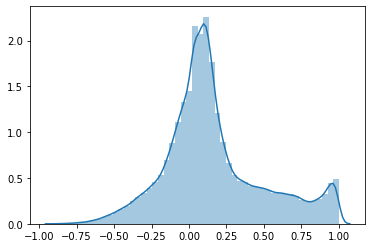

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

list_c=[]
for k in tru_pred_tru.keys():
    for k1 in dec_pred_tru.keys():
        result = 1 - spatial.distance.cosine(tru_pred_tru[k], dec_pred_tru[k1])
        list_c.append(result)
       
sns.distplot(list_c)
max=list_c[0]
min=list_c[0]
for val in list_c:
    if(val>max):
        max=val
    if(val<min):
        min=val


print(max,min)

### Finding Cosine Similarity between pairwise data that yeild true positive and false negative values

0.9048966277889382 -0.8479326502949416


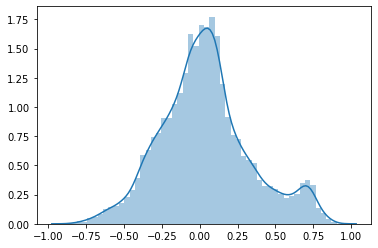

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

list_c=[]
for k in tru_pred_tru.keys():
    for k1 in tru_pred_dec.keys():
        result = 1 - spatial.distance.cosine(tru_pred_tru[k], tru_pred_dec[k1])
        list_c.append(result)
       
sns.distplot(list_c)
max=list_c[0]
min=list_c[0]
for val in list_c:
    if(val>max):
        max=val
    if(val<min):
        min=val


print(max,min)

### FInding Cosine Similarity between pairwise data that yeild false negative and true negative values

0.9009442872383342 -0.7523691156503096


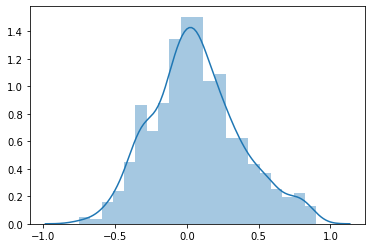

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

list_c=[]
for k in dec_pred_dec.keys():
    for k1 in tru_pred_dec.keys():
        result = 1 - spatial.distance.cosine(dec_pred_dec[k], tru_pred_dec[k1])
        list_c.append(result)
       
sns.distplot(list_c)
max=list_c[0]
min=list_c[0]
for val in list_c:
    if(val>max):
        max=val
    if(val<min):
        min=val


print(max,min)

### Finding Cosine Similarity between pairwise data that yeild true negative and false positive data

0.9857908137761888 -0.8142453740402182


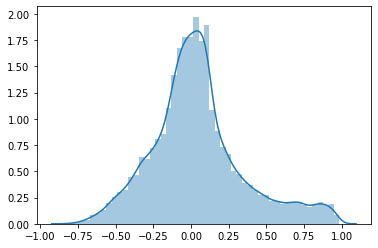

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

list_c=[]
for k in dec_pred_dec.keys():
    for k1 in dec_pred_tru.keys():
        result = 1 - spatial.distance.cosine(dec_pred_dec[k], dec_pred_tru[k1])
        list_c.append(result)
       
sns.distplot(list_c)
max=list_c[0]
min=list_c[0]
for val in list_c:
    if(val>max):
        max=val
    if(val<min):
        min=val


print(max,min)

## Combined; Are data picked up from the same sample?? 
### All data predicted as true are they picked from same sample?
    
Finding Relation between data that is truthful,predicted as truthful and deceptive but predicted as truthful:(tru_pred_tru,dec_pred_tru)

In [31]:
# All data predicted as truthful are stored in tru
tru={}
k=0
for elem in tru_pred_tru.values():
    tru[k]=elem
    k +=1
for elem1 in dec_pred_tru.values():
    tru[k]=elem1
    k +=1

In [32]:
from scipy.stats import f_oneway
t, p =  f_oneway(*tru.values())
p

0.13720839921527586

Well, the p value suggest they are indeed picked from same space

### All data predicted as deceptive are they picked from same sample?

Finding Relation between data that is deceptive,predicted as deceptive and truthful but predicted as deceptive: (dec_pred_dec,tru_pred_dec)

In [33]:
# All data predicted as truthful are stored in tru
dec={}
k=0
for elem in dec_pred_dec.values():
    dec[k]=elem
    k +=1
for elem1 in tru_pred_dec.values():
    dec[k]=elem1
    k +=1

In [34]:
from scipy.stats import f_oneway
t, p =  f_oneway(*dec.values())
p

0.8544341150083619

Well, the p value suggest they are indeed picked from same space; also data predicted as deceptive(TN and FN) is more similar to each other than those predicted as truthful(TP and FP)

## Compare Metrics from individual datasets

In [36]:
### Empty list that will hold different metric values from different data sources
Acc, Pre, Re, Auc=[],[],[],[]

### Testing Model on Youtube data
Preprocessing are performed on data collected from youtube

In [37]:
df_list, label_list = [], []
for filename in glob.glob(os.path.join(direc, '*.csv')):
    if "Youtube" in filename:
            df_individualfile = pd.read_csv(filename)
            count = len(df_individualfile.index)
            if(count>0):
                label = df_individualfile.loc[:, "label"].unique()[0]
                df_individualfile.drop(["name", "frameTime", "Unnamed: 0", "label"], axis = 1, inplace = True)
                df_individualfile.set_index(pd.date_range(start='2000-01-01', end='2020-01-12', 
                                                          periods = df_individualfile.shape[0]), inplace = True)
                df_individualfile.drop_duplicates(inplace = True)
                df_list.append(df_individualfile)
                label_list.append(label)

import datetime
deltatime = (pd.to_datetime("2020-01-12") - pd.to_datetime("2000-01-01"))/1599
deltatime

df_list_interpolated = []
for df in df_list:
    upsampled = df.resample(deltatime)
    df_interpolated = upsampled.interpolate(method = 'linear')
    #break
    df_list_interpolated.append(df_interpolated)

for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)


(1541, 26) 107


### Remove data that does not have 1600 frames

In [38]:
df_list_interpolated.pop(107)
label_list.pop(107)

X_test = np.array(pd.concat(df_list_interpolated, axis = 0)).reshape(-1, 1600, 26)
X_test.shape

y_test = pd.Series(label_list).apply(lambda y: 1 if y == "Truthful" else 0)
y_test=y_test.to_numpy()
type(y_test)

numpy.ndarray

### Loading Model && Calculating the Metrics for Youtube data

In [39]:
model = tf.keras.models.load_model('best_model_new.h5')
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
results = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
for elem in X_test:
    m=elem.mean(axis=0)
    fl.append(m)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.6 else 1), classes = [0, 1])


from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
prec = precision_score(y_test, y_pred_det , average="macro")
rec = recall_score(y_test, y_pred_det , average="macro")
fsc= f1_score(y_test, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_test, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_test, y_pred_det)

Acc.append(accu)
Pre.append(prec)
Re.append(rec)
Auc.append(auc)

210/210 [==============================] - 8s 40ms/sample - loss: 0.8690 - acc: 0.5286
Cohens kappa: 0.139562
ROC AUC: 0.581108


## Test Model on Bag of lies data
Preprocessing steps are performed on data collected from Bag of lies

In [40]:
df_list, label_list = [], []
for filename in glob.glob(os.path.join(direc, '*.csv')):
    if "BagOfLies" in filename:
            df_individualfile = pd.read_csv(filename)
            count = len(df_individualfile.index)
            if(count>0):
                label = df_individualfile.loc[:, "label"].unique()[0]
                df_individualfile.drop(["name", "frameTime", "Unnamed: 0", "label"], axis = 1, inplace = True)
                df_individualfile.set_index(pd.date_range(start='2000-01-01', end='2020-01-12', 
                                                          periods = df_individualfile.shape[0]), inplace = True)
                df_individualfile.drop_duplicates(inplace = True)
                df_list.append(df_individualfile)
                label_list.append(label)

import datetime
deltatime = (pd.to_datetime("2020-01-12") - pd.to_datetime("2000-01-01"))/1599
deltatime

df_list_interpolated = []
for df in df_list:
    upsampled = df.resample(deltatime)
    df_interpolated = upsampled.interpolate(method = 'linear')
    #break
    df_list_interpolated.append(df_interpolated)

for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)

X_test = np.array(pd.concat(df_list_interpolated, axis = 0)).reshape(-1, 1600, 26)
X_test.shape

y_test = pd.Series(label_list).apply(lambda y: 1 if y == "Truthful" else 0)
y_test=y_test.to_numpy()
type(y_test)

numpy.ndarray

### Loading Model && Calculating the Metrics for Bag of lies data

In [41]:
model = tf.keras.models.load_model('best_model_new.h5')
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
results = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
for elem in X_test:
    m=elem.mean(axis=0)
    fl.append(m)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.6 else 1), classes = [0, 1])

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
prec = precision_score(y_test, y_pred_det , average="macro")
rec = recall_score(y_test, y_pred_det , average="macro")
fsc= f1_score(y_test, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_test, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_test, y_pred_det)

Acc.append(accu)
Pre.append(prec)
Re.append(rec)
Auc.append(auc)


325/325 [==============================] - 16s 50ms/sample - loss: 0.8909 - acc: 0.5231
Cohens kappa: -0.018578
ROC AUC: 0.490684


## Test Model on CSC data
Preprocessing steps are performed on data collected from CSC dataset

In [42]:
df_list, label_list = [], []
count =0 
for filename in glob.glob(os.path.join(direc, '*.csv')):
    if "CSC" in filename:
        if(len(df_list)<300):
            df_individualfile = pd.read_csv(filename)
            count = len(df_individualfile.index)
            if(count>0):
                label = df_individualfile.loc[:, "label"].unique()[0]
                df_individualfile.drop(["name", "frameTime", "Unnamed: 0", "label"], axis = 1, inplace = True)
                df_individualfile.set_index(pd.date_range(start='2000-01-01', end='2020-01-12', 
                                                          periods = df_individualfile.shape[0]), inplace = True)
                df_individualfile.drop_duplicates(inplace = True)
                df_list.append(df_individualfile)
                label_list.append(label)


import datetime
deltatime = (pd.to_datetime("2020-01-12") - pd.to_datetime("2000-01-01"))/1599
deltatime

df_list_interpolated = []
for df in df_list:
    upsampled = df.resample(deltatime)
    df_interpolated = upsampled.interpolate(method = 'linear')
    #break
    df_list_interpolated.append(df_interpolated)

for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)

X_test = np.array(pd.concat(df_list_interpolated, axis = 0)).reshape(-1, 1600, 26)
X_test.shape

y_test = pd.Series(label_list).apply(lambda y: 1 if y == "Truthful" else 0)
y_test=y_test.to_numpy()
type(y_test)

numpy.ndarray

### Loading Model && Calculating the Metrics for CSC data

In [43]:
model = tf.keras.models.load_model('best_model_new.h5')
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
results = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
for elem in X_test:
    m=elem.mean(axis=0)
    fl.append(m)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.6 else 1), classes = [0, 1])

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
prec = precision_score(y_test, y_pred_det , average="macro")
rec = recall_score(y_test, y_pred_det , average="macro")
fsc= f1_score(y_test, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_test, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_test, y_pred_det)

Acc.append(accu)
Pre.append(prec)
Re.append(rec)
Auc.append(auc)

300/300 [==============================] - 13s 45ms/sample - loss: 0.8373 - acc: 0.6033
Cohens kappa: 0.297331
ROC AUC: 0.651232


## Test Model on Trial data
Preprocessing steps are performed on data collected from trial dataset

In [44]:
df_list, label_list = [], []
for filename in glob.glob(os.path.join(direc, '*.csv')):
    if "trial" in filename:
            df_individualfile = pd.read_csv(filename)
            count = len(df_individualfile.index)
            if(count>0):
                label = df_individualfile.loc[:, "label"].unique()[0]
                df_individualfile.drop(["name", "frameTime", "Unnamed: 0", "label"], axis = 1, inplace = True)
                df_individualfile.set_index(pd.date_range(start='2000-01-01', end='2020-01-12', 
                                                          periods = df_individualfile.shape[0]), inplace = True)
                df_individualfile.drop_duplicates(inplace = True)
                df_list.append(df_individualfile)
                label_list.append(label)

import datetime
deltatime = (pd.to_datetime("2020-01-12") - pd.to_datetime("2000-01-01"))/1599
deltatime

df_list_interpolated = []
for df in df_list:
    upsampled = df.resample(deltatime)
    df_interpolated = upsampled.interpolate(method = 'linear')
    #break
    df_list_interpolated.append(df_interpolated)

for i, df in zip(np.arange(len(df_list_interpolated)), df_list_interpolated):
    if df.shape[0] != 1600:
        print(df.shape, i)
        
X_test = np.array(pd.concat(df_list_interpolated, axis = 0)).reshape(-1, 1600, 26)
X_test.shape

y_test = pd.Series(label_list).apply(lambda y: 1 if y == "Truthful" else 0)
y_test=y_test.to_numpy()
type(y_test)

numpy.ndarray

### Loading Model && Calculating the Metrics for trial data

In [45]:
model = tf.keras.models.load_model('best_model_new.h5')
y_true = preprocessing.label_binarize(y_test, classes = [0, 1])
results = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
for elem in X_test:
    m=elem.mean(axis=0)
    fl.append(m)
y_pred_det = preprocessing.label_binarize(pd.Series(y_pred[:, 0]).apply(lambda y: 0 if y<0.6 else 1), classes = [0, 1])

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,cohen_kappa_score,roc_auc_score, accuracy_score
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
prec = precision_score(y_test, y_pred_det , average="macro")
rec = recall_score(y_test, y_pred_det , average="macro")
fsc= f1_score(y_test, y_pred_det , average="macro")
# kappa
kappa = cohen_kappa_score(y_test, y_pred_det)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred_det)
print('ROC AUC: %f' % auc)
accu = accuracy_score(y_test, y_pred_det)

Acc.append(accu)
Pre.append(prec)
Re.append(rec)
Auc.append(auc)

121/121 [==============================] - 10s 81ms/sample - loss: 0.8500 - acc: 0.5620
Cohens kappa: 0.337712
ROC AUC: 0.668579


### Store all values from Accuracy, Precision, Recall, Area Under Curve lists to their respective data source

In [46]:
you=[Acc[0],Pre[0],Re[0],Auc[0]]
bg=[Acc[1],Pre[1],Re[1],Auc[1]]
cs=[Acc[2],Pre[2],Re[2],Auc[2]]
tr=[Acc[3],Pre[3],Re[3],Auc[3]]

### Generating bar plot for different Metric scores obtained when testing the model on different datasets.

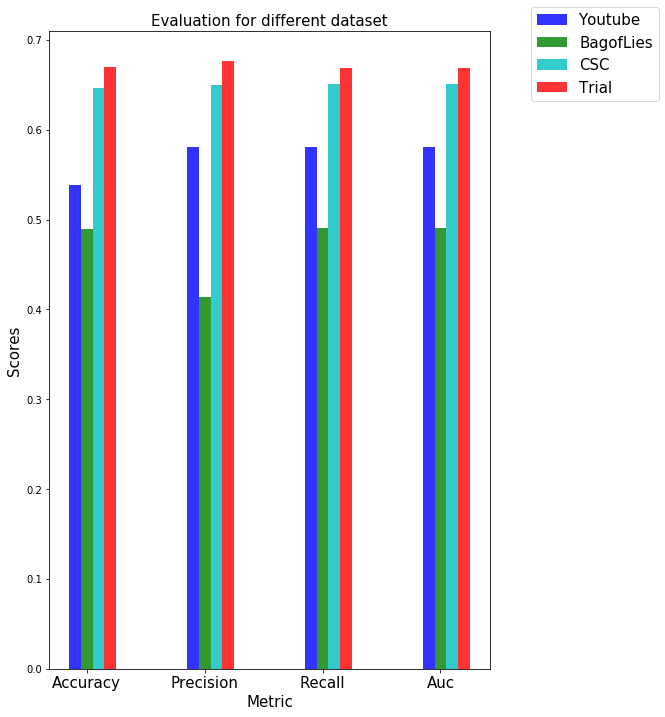

In [47]:
# create plot
labels=["Accuracy","Precision","Recall","Auc"]
fig = plt.figure(figsize=(10,10))
#fig, ax = plt.subplots()
index = np.arange(len(labels))
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, you, bar_width,
alpha=opacity,
color='b',
label='Youtube')

rects2 = plt.bar(index + bar_width, bg, bar_width,
alpha=opacity,
color='g',
label='BagofLies')

rects2 = plt.bar(index + 2*bar_width, cs, bar_width,
alpha=opacity,
color='c',
label='CSC')

rects2 = plt.bar(index + 3*bar_width, tr, bar_width,
alpha=opacity,
color='r',
label='Trial')

plt.xlabel('Metric',fontsize=15)
plt.ylabel('Scores',fontsize=15)
plt.title('Evaluation for different dataset',fontsize=15)
plt.xticks(index + bar_width, ("Accuracy","Precision","Recall","Auc"),fontsize=15)
plt.legend(bbox_to_anchor=(1.4, 1.05),fontsize=15)

plt.tight_layout()
plt.show()